# Jetracer Steering Control Calibration Tool
Author: George Gorospe, george.e.gorospe@gmail.com (updated 12/17/2023)

About: In this notebook we'll find the parameters of our racer to calibrate our steering control.

Utimately, we'd like to control our racer with the gamepad so we can collect information about steering. To do this we need to take controller inputs and produce commands for our robot.

## **** IMPORTANT ****
### Before running this notebook you MUST elevate your robot off the ground.
### Make sure that the robot's wheels are free to rotate and that the robot is on a stable suppot.
### This notebook will cause the robots wheels to turn very quickly.

### BE CAREFUL!

## ROBOT SETUP
### Before running the cells of this notebook, ensure that the robot's propulsion system is on.
### On your manual controller, flip the switch to give command of the racer to the computer.

In [ ]:
# Importing required Libaries
import cv2, glob
import ipywidgets
import ipywidgets.widgets as widgets
from ipywidgets import Layout

import traitlets
from IPython.display import display
from jetcam.utils import bgr8_to_jpeg

# Style and Layout
Style = {'description_width': 'initial'}

# Setup of NvidiaRacecar Object: Used to contro the steering and throttle of our AI racer.
from jetracer.nvidia_racecar import NvidiaRacecar
car = NvidiaRacecar()

## MECHATRONICS: Controlling the Racer with the Computer
The computer can produce commands to control the motion of the racer's chassis. With the computer, we can change the steering angle and control the car's throttle.

Here, we're going to explore which commands are used for turning Left/Right and which commands are used for forwards/backwards.

To aid us in the process we'll use graphical controls within this notebook.

The following cell, sets up the graphical controls and connects those controls with callback functions, which execute when there is a change to the graphical control. 
Finally, those callback functions use the NvidiaRaceCar object we created earlier, "car" to send commands to the racer.

In [ ]:
# Setup of Steering/Throttle graphic user interface (GUI)
# 1. Create the graphic controls
# 2. Connect callback functions and connect them to the controls so they activate when the controls are used
# 3. Create a display for the controls with instructions

###### 1. Creating graphic controls

# Steering Control textbox
# We want to explore the full range of the servo by issuing commands.
steering_control = widgets.FloatText(value=.2, description='car.steering =', step = 0.01, style =  Style,layout=Layout(width='150px', height='30px'))
throttle_control = widgets.FloatText(value=.26, description='car.throttle =', step = 0.01, style =  Style,layout=Layout(width='150px', height='30px'))


###### 2. Connecting callback functions and connecting them to the controls

# This fuction executes when the steering value is changed
def steering_callback(change):
    car.steering = steering_control.value # Issue servo steering command by the computer to the vehicle's steering servo

def throttle_callback(change):
    car.throttle = throttle_control.value # Issue throttle command by the computer to the vehicle's speed controller

# Callback connections (Observers)
steering_control.observe(steering_callback, names='value') # Observes the steering_control widget
throttle_control.observe(throttle_callback, names='value') # Observes the throttle_control widget

###### 3. Display the controls with instructions
instructions_01 = widgets.Label(value=str("INSTRUCTIONS: Use the following controls to explore your car's control parameters, then write the parameters in the cell below:"))
instructions_02 = widgets.Label(value=str("Use the car.steering box to find the values that turn the car to the far right and the far left."))
instructions_03 = widgets.Label(value=str("Use the car.throttle box to find the values that make the car's propulsion system move forward and backwards, then enter the values just before movement happens."))

control_UI = widgets.VBox([instructions_01, instructions_02, steering_control, instructions_03, throttle_control])

display(control_UI)

In [ ]:
# Fill in these values after working with the graphical interface above
# Important info to copy to other notebooks later

#### CAR STEERING PARAMETERS
steering_center = -0.13              #### FIND THE VALUE FOR CENTER AND ENTER HERE
steering_left_max = 0.33              #### FIND THE VALUE FOR MAXIMUM LEFT AND ENTER HERE
steering_right_max = -0.64            #### FIND THE VALUE FOR MAXIMUM RIGHT AND ENTER HERE

#### CAR THROTTLE PARAMETERS
throttle_forward_just_before_rolling_or_noise = 0.23        #### FIND VALUE THAT CAUSES FORWARD MOTION, ENTER VALUE BEFORE MOTION STARTS
throttle_reverse_just_before_rolling_or_noise = 0.29        #### FIND THE VALUE THAT CAUSES REVERSE MOTION, ENTER VALUE BEFORE MOTION STARTS
dead_throttle = 0.26                                        #### DEAD THROTTLE IS BETWEEN OTHER TWO VALUES, NO MOTION SHOULD OCCUR DURING DEAD THROTTLE

In [ ]:
# Calculations from Steering Parameters
# The following calculations help to actuate the car
throttle_reverse_range = 0.05   ### HOW MUCH SIGNAL IS ADDED WHEN REVERSE BUTTON IS PRESSED
throttle_forward_range = 0.13    ### HOW MUCH SIGNAL IS ADDED WHEN FORWARD BUTTON IS PRESSED

# Steering calculations
right_steering_range = abs(steering_right_max - steering_center)
left_steering_range = abs(steering_left_max - steering_center)
steering_range = right_steering_range + left_steering_range

## Gamepad Calibration for Steering and throttle
Next, we'll use the values we determined earlier for creating a mapping from our controller to the robot commands.

### Connecting the GamePad and Receiving Inputs
Next, we'd like to connect the GamePad to our computer so that we can take inputs to be used later for steering and throttle.

This process is very similar to the process used in the "teleoperation" notebook.

The first thing we want to do is create an instance of the ``Controller`` widget, which we'll use to drive our robot.

The ``Controller`` widget takes a ``index`` parameter, which specifies the number of the controller.  This is useful in case you have multiple controllers attached, or some gamepads *appear* as multiple controllers.  

To determine the index of the controller you're using,
1. Connect your gamepad to your laptop via bluetooth.
2. Visit [http://html5gamepad.com](http://html5gamepad.com).  
3. Follow the website directions and press buttons on the gamepad you're using, the website will
4. Remember the ``index`` of the gamepad that is responding to the button presses

Your gamepad input can now be routed into this notebook.
Next we'll confirm the the input with a display.

In [ ]:
import ipywidgets.widgets as widgets

controller = widgets.Controller(index=0)  # replace with index of your controller
# Gamepad Steering: Left (1.0) --- Center (0.0) --- Right (-1.0)
# Gamepad Throttle: Forward (1.0) --- Zero Throttle (0.0) --- NOT USED (0.0 to -1.0)
# Gamepad Reverse: Reverse (1.0) --- Zero Reverse Throttle (0.0)

# Building gamepad UI
instructions_04 = widgets.Label(value=str("Press any button to ensure that the controller is active and connected to the computer."))
gamepad_UI = widgets.VBox([instructions_04, controller])

display(gamepad_UI)

# Connecting the Gamepad Input to the Robot's Motors
So far, we've found the parameters for controlling our robot from the computer and we have connected our gamepad to the computer.

We are now ready to make the final connections within this notebook that connect the gamepad to the robot's motors.


In [ ]:
# Setup of Gamepad to Robot graphic user interface (GUI)
# 1. Create the graphic indicators to show gamepad input and commanded output
# 2. Create links between the gamepad input and the input indicators
# 3. Map inputs to robot outputs based on robot parameters
# 4. Use observers to connect output indicators to callback functions for commanding the robot
# 5. Create a display for gamepad indicators and output indicators

###### 1. Creating graphic indicators for both the input and output

################ GAMEPAD INDICATORS #####################
# Float Slider representation of steering input from gamepad
gamepad_steering_input = widgets.FloatSlider(
    value=0.0, 
    min=-1.0, 
    max=1.0, 
    step = 0.01,
    description='Steering:', 
    continuous_update=False, 
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

# Color Bar representation of the throttle input from gamepad
gamepad_throttle_input = widgets.IntProgress(
    value=0,
    min=0,
    max=100.0,
    description='Throttle:',
    bar_style='success', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'green'},
    orientation='horizontal',
)
gamepad_throttle_input_readout = widgets.BoundedFloatText(
    value=0, min=-1.0, max=1.0, layout=Layout(width='70px',height='50px'))

# Color Bar representation of the reverse input from gamepad
gamepad_reverse_input = widgets.IntProgress(
    value=0,
    min=0,
    max=100.0,
    step = 0.01,
    description='Reverse:',
    bar_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'red'},
    orientation='horizontal'
)
gamepad_reverse_input_readout = widgets.BoundedFloatText(
    value=0, min=-1.0, max=1.0, layout=Layout(width='70px'))

################ OUTPUT INDICATORS #####################
# Float Slider representation of steering output to the robot
output_STEERING = widgets.FloatSlider(
    value=steering_center, 
    min=steering_right_max, 
    max=steering_left_max, 
    step = 0.01,
    description='Steering:', 
    continuous_update=False, 
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

# Color Bar representation of the throttle input from gamepad
output_THROTTLE = widgets.FloatSlider(
    value=dead_throttle,
    min=throttle_forward_just_before_rolling_or_noise - throttle_forward_range,
    max=dead_throttle+throttle_forward_range,
    step = 0.01,
    description='Throttle:',
    bar_style='success', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'green'},
    orientation='horizontal',
)
#gamepad_throttle_input_readout = widgets.BoundedFloatText(
#    value=dead_throttle, min=throttle_forward_just_before_rolling_or_noise - throttle_forward_range, max=dead_throttle, layout=Layout(width='70px'))

# Color Bar representation of the reverse input from gamepad
output_REVERSE = widgets.FloatSlider(
    value=dead_throttle,
    min=dead_throttle,
    max=throttle_reverse_just_before_rolling_or_noise + throttle_reverse_range,
    step = 0.01,
    description='Reverse:',
    bar_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'red'},
    orientation='horizontal'
)


###### 2. Create Links between Gampad input and input indicators
# GAMEPAD INPUTS
input_link_STEERING = traitlets.dlink((controller.axes[0], 'value'), (gamepad_steering_input, 'value'))
input_link_THROTTLE = traitlets.dlink((controller.axes[3], 'value'), (gamepad_throttle_input, 'value'), transform=lambda x: -x*100)
input_link_REVERSE = traitlets.dlink((controller.buttons[7], 'value'), (gamepad_reverse_input, 'value'), transform=lambda x: x*100)
input_readout_link_THROTTLE = traitlets.dlink((controller.axes[3], 'value'), (gamepad_throttle_input_readout, 'value'))
input_readout_link_REVERSE = traitlets.dlink((controller.buttons[7], 'value'), (gamepad_reverse_input_readout, 'value'))

##### 3. Map inputs to robot outputs based on robot parameters
output_link_STEERING = traitlets.dlink((controller.axes[0], 'value'), (output_STEERING, 'value'), transform=lambda x: -x * right_steering_range + steering_center)
output_link_THROTTLE= traitlets.dlink((controller.axes[3], 'value'), (output_THROTTLE, 'value'), transform=lambda x: x*throttle_forward_range + throttle_forward_just_before_rolling_or_noise)
output_link_REVERSE = traitlets.dlink((controller.buttons[7], 'value'), (output_REVERSE, 'value'), transform=lambda x: x*throttle_reverse_range + throttle_reverse_just_before_rolling_or_noise)

##### 4. Use observers to connect output indicators to callback functions for commanding the robot
# Callback function executes when gamepad's throttle is changed, 'change' is a dictionary containing the 'old' and 'new' values
def throttle_command(change):
    car.throttle = round(change.owner.value,2) # Issue throttle command by the computer to the vehicle's speed controller

# Callback function executes when gamepad's steering value is changed, 'change' is a dictionary containing the 'old' and 'new' values
def steering_command(change): # (-1.00000, 1.00000)
#   global steering_cmd, steering_label
#   steering_raw = 
#   steering_cmd = round(steering_raw,2) # The new value received from the gamepad (float) (-)
    car.steering = change.owner.value

# Callback function executes when gamepad's reverse button value is changed, 'change' is a dictionary containing the 'old' and 'new' values
def reverse_command(change):
    #global reverse_cmd
    #reverse_cmd = round(change.owner.value,2) # The new value received from the gamepad (float)
    #reverse_cmd_textbox.value = reverse_cmd
    car.throttle = change.owner.value
    
output_STEERING.observe(steering_command, names='value')
output_THROTTLE.observe(throttle_command, names='value')
output_REVERSE.observe(throttle_command, names='value')

###### 5. Create a display for gamepad indicators and output indicators
sect_style = dict(
    font_weight='bold',
    font_size='30px',
    text_decoration = 'underline'
)
cs1 = dict(
    font_weight='bold',
    font_variant="small-caps",
    font_size='22px'
)
cs2 = dict(
    font_weight='bold',
    font_size='16px'
)
gamepad_caption = widgets.Label(value=str("Inputs from the Gamepad"), style=cs1)
gamepad_information = widgets.Label(value=str("The inputs from the gamepad range from -1.0 to 1.0. The throttle input is reversed."))
gamepad_input_display = widgets.HBox([gamepad_steering_input, 
                                      gamepad_throttle_input,
                                      gamepad_throttle_input_readout, 
                                      gamepad_reverse_input, 
                                      gamepad_reverse_input_readout])

output_caption = widgets.Label(value=str("Outputs to the Robot"), style=cs1)
output_information_1 = widgets.Label(value=str("The values for output to the robot come from the parameters you found earlier, go back and check!"))
output_information_2 = widgets.Label(value=str("In this mapping, the steering and the throttle are both reversed!"))
output_display = widgets.HBox([output_STEERING, output_THROTTLE, output_REVERSE])

section_caption_1 = widgets.Label(value=str("The gamepad output is now connected to the robot's motors."),
                                          style=sect_style) 

mapping_caption = widgets.Label(value=str("The outputs below reflect a mapping of the input values (above) to the values we found earlier that control the racer motors."),
                                          style=cs2)
display(section_caption_1)
display(widgets.VBox([gamepad_caption, gamepad_information, gamepad_input_display]))
display(mapping_caption)
display(widgets.VBox([output_caption, output_information_1, output_information_2, output_display]))

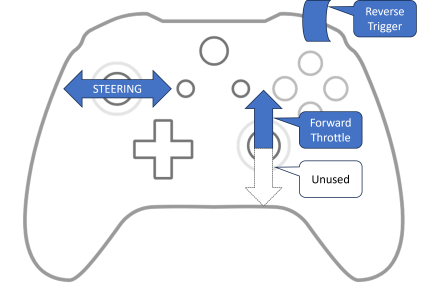